In [1]:
options(warn = -1)

library(ggplot2)
library(corrplot)
library(glmnet)
library(lars)
library(tidyverse)
library(gglasso)
library(caret)
library(here)
library(car)
library(grpreg)
library(scales)
library(olsrr)

corrplot 0.92 loaded

Loading required package: Matrix

Loaded glmnet 4.1-8

Loaded lars 1.3


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


here() starts at C:/Users/david/Desktop/GT/Courses/ISYE 6414_Regression Analysis/TA/2025Summer/Git_old/Main-Modules/Module4

Loading required package: ca

### Background
This example looks at data from Alabama, Arkansas, Louisiana, and North Carolina
detailing Medicaid recipients in 2011.  Medicaid is an income based health 
insurance program managed by the United States federal government that provided 
benefits to around 85 million persons, nationwide, in 2022.

In this example, we will build multiple models to examine the following questions:

1. What factors impact the healthcare cost due to emergency department encounters?
2. Is access to primary care providers associated with healthcare costs due to 
emergency department encounters?

Disclaimer: This analysis of healthcare cost for the Medicaid population using 
the MAX claims data is in compliance with the study protocol approved by the 
Georgia Tech Internal Review Board (IRB) and by CMS. Do NOT use the data 
provided for this analysis for purposes other than the study in this lesson. 


### Reading the Data

In [3]:
# read in the data file
data_file <- here("DataADULT.csv")
dataAdult <- read.csv(data_file, header=TRUE)
attach(dataAdult)

### Data Description
Response Variable:

*EDcost:* The response variable of interest.  Emergency Department cost aggregated at the census tract level

Predictors and Other Variables:

*PMPM:* Per member per month - Total number of enrollment months aggregated by census tract
*State:* State of the member
*GEOID:* Census tract identification number
*ED:* Number of emergency department claims
*HO:* Number of hospitalization claims
*PO:* Number of physician office claims
*BlackPop:* One of example of multiple characteristics shwoing the percentages 
of Medicaid-enrolled adults of various populations
*Unemployment:* One of 13 variables quantifying other possibly health-related factors


## Preparing the Data
In the code below, we scale the response variable EDCost and the utilization
variables using PMPM to allow for comparison across census tracts.  Each census 
tract has different number of enrollees, and each enrollee can have a different 
number of enrollment months.  Because of this, scaling EDcost by PMPM allows a comparison of cost per enrollee month across census tracts.


In [4]:
# Rescale outcome/response variable
EDCost.pmpm = EDCost/PMPM

# Rescale utilization
dataAdult$PO = PO/PMPM
dataAdult$HO = HO/PMPM

detach(dataAdult)
attach(dataAdult)


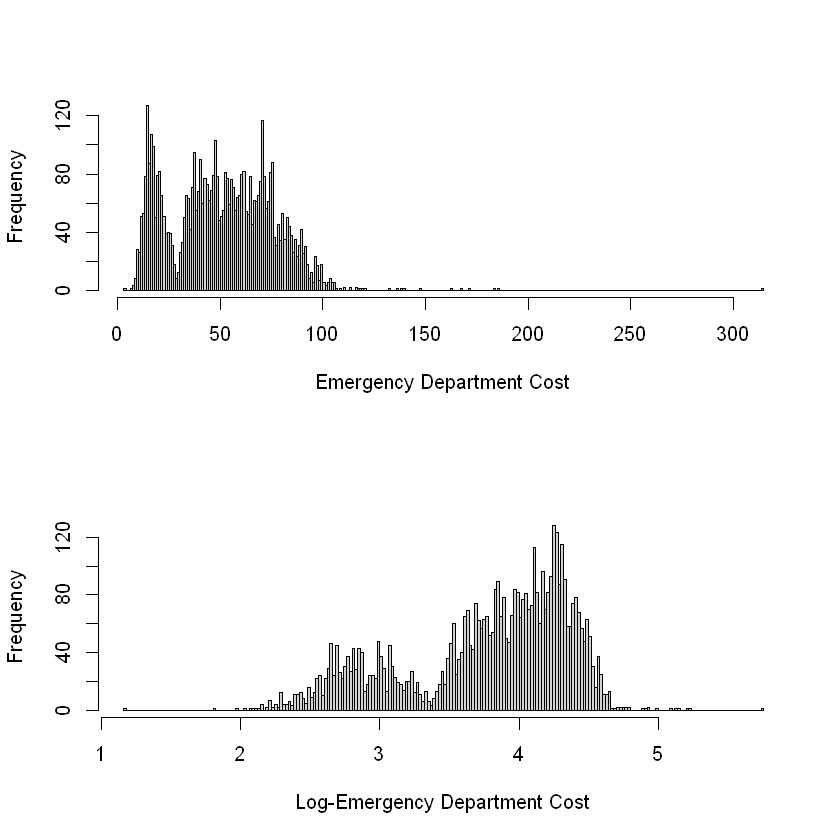

In [5]:
## Histogram of the response variable
par(mfrow=c(2,1))
hist(EDCost.pmpm, breaks=300, xlab="Emergency Department Cost", main="")
hist(log(EDCost.pmpm), breaks=300, xlab="Log-Emergency Department Cost", main="")

log.EDCost.pmpm = log(EDCost.pmpm)


For histogram of EDCost.pmpm (top one), the shape of the distribution is skewed with the data concentrated into a rather small range, indicating that the normality assumption might not hold.

The histogram of the log transformed data is on the bottom plot. The log transformation performs well in centering the data while spreading the data over a wider range. We also see here that we have two clear modes in the distribution of the response variable after transforming the data. It is our hope that this bimodality will be explained by the predicting variables considered in this study.

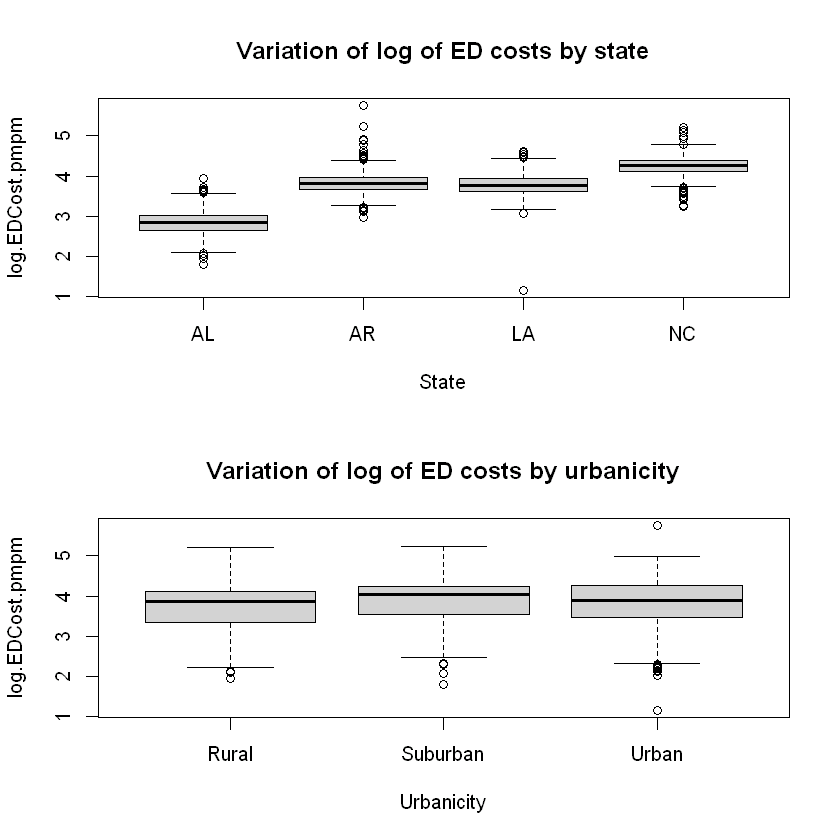

In [6]:
# Response variable vs categorical prediciting variables
par(mfrow=c(2,1))
boxplot(log.EDCost.pmpm ~ State, main = "Variation of log of ED costs by state")
boxplot(log.EDCost.pmpm ~ Urbanicity, main = "Variation of log of ED costs by urbanicity")

We use side-by-side box plots to assess the relationship between the response variable and the qualitative predicting variables.

When comparing the EDCost.pmpm across states, we see clear differences in the median ED cost, with North Carolina having the higher median and Alabama having the lowest median. 

The differences among the medians across the three different urbanicity levels (rural, suburban, and urban) are not strikingly different. 

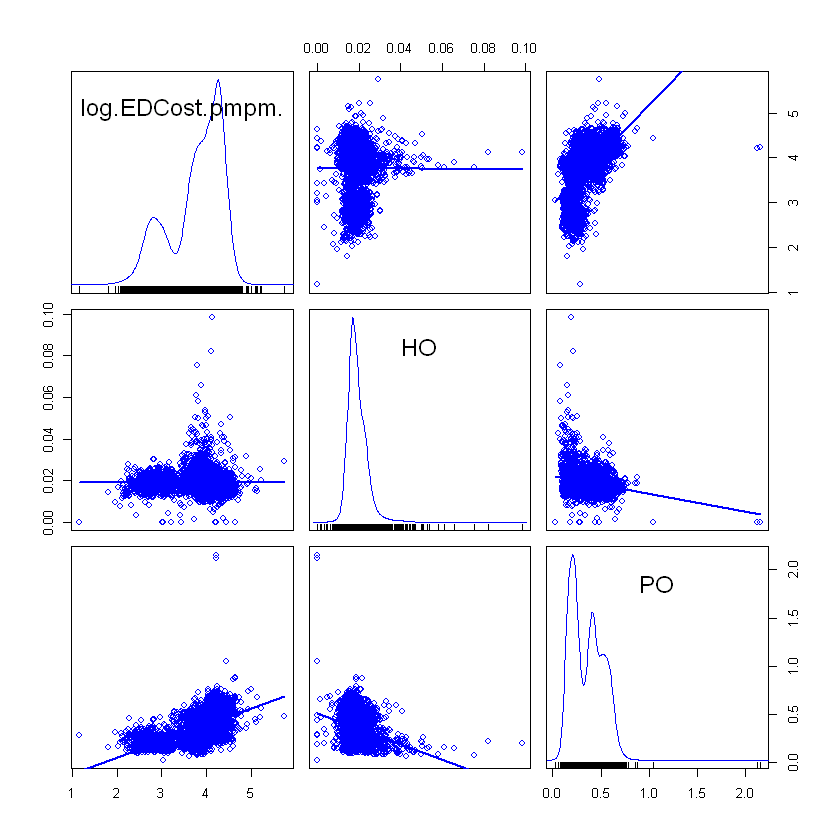

In [7]:
# Scatterplot matrix plots
par(mfrow=c(1,1))

# Response vs Utilization
scatterplotMatrix(~ log(EDCost.pmpm) + HO + PO, data=dataAdult, smooth=FALSE)

We use matrix plot to explore the relationsip between the response and quantative predictive variables.

There is strong positive correlation between the ED cost and the utilization of physician office, but not a strong relationship with in-patient care utilization. Moreover, there is only a weak correlation between the utilization of physician office and in-patient utilization.

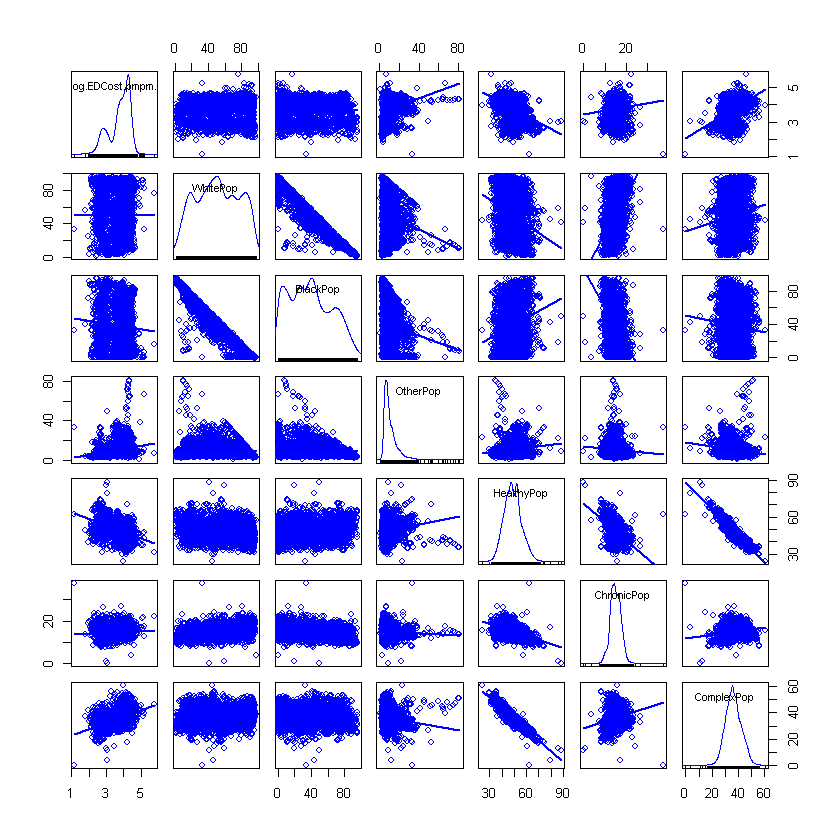

In [8]:
# Response vs Population Characteristics
scatterplotMatrix(~ log(EDCost.pmpm) + WhitePop + BlackPop + OtherPop + HealthyPop + 
                      ChronicPop + ComplexPop, data=dataAdult,smooth=FALSE)

This matrix plot is for population characteristics, with six population categories to consider.

There is a weak relationship of the response with respect to black and white population percentages. There is also a negative relationship with the percentage of adults that are considered healthy, a weak positive relationship with the percentage of adults with chronic conditions. Strong positive relationship with a percentage of population with complex conditions. Moreover, there's a strong negative relationship between percentage of black population and percentage of white population.

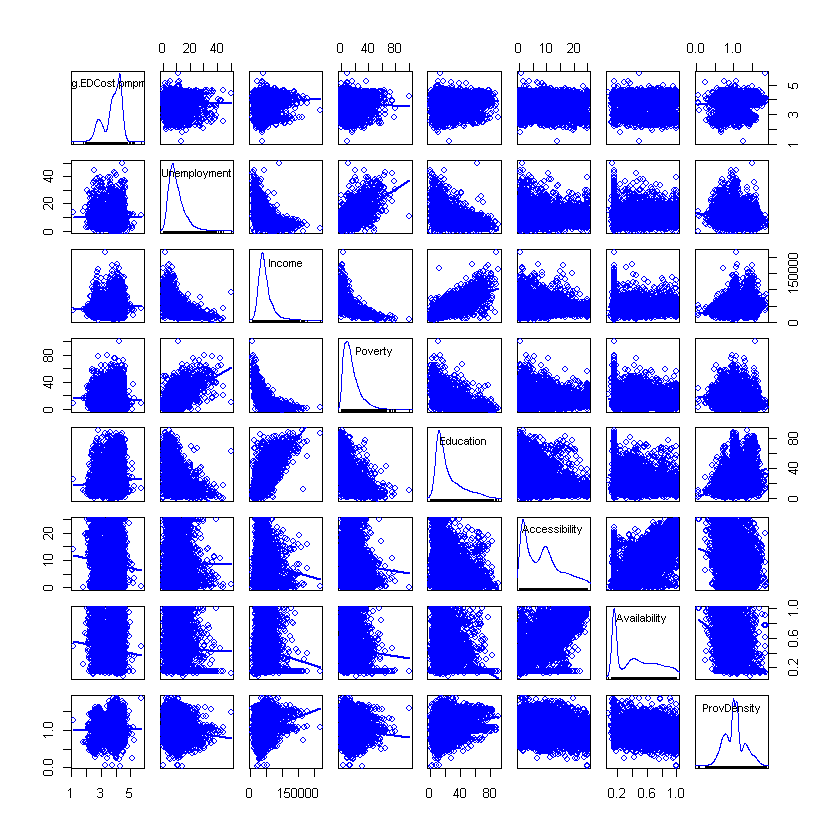

In [9]:
# Response vs Socioeconomic and Environmental Characteristics
scatterplotMatrix(~ log(EDCost.pmpm) + Unemployment + Income + Poverty + Education + 
                      Accessibility + Availability + ProvDensity, data=dataAdult, smooth=FALSE)

There's no obvious correlation between the response variable and economic and environmental characteristics. A weak negative correlation is observed between reponse and income. 

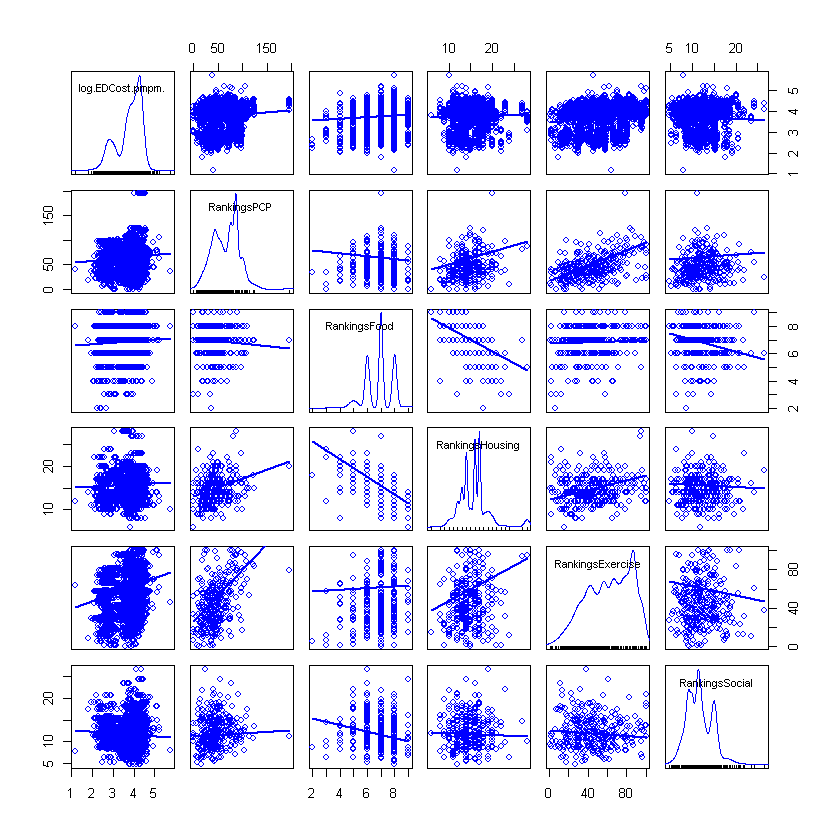

In [10]:
# Response vs County Health Rankings
scatterplotMatrix(~ log(EDCost.pmpm) + RankingsPCP + RankingsFood + RankingsHousing + 
                      RankingsExercise + RankingsSocial, data=dataAdult, smooth=FALSE)


A mild positive correlation can be observed between the reponse variable and RankingExercise.


## Correlation matrix plot

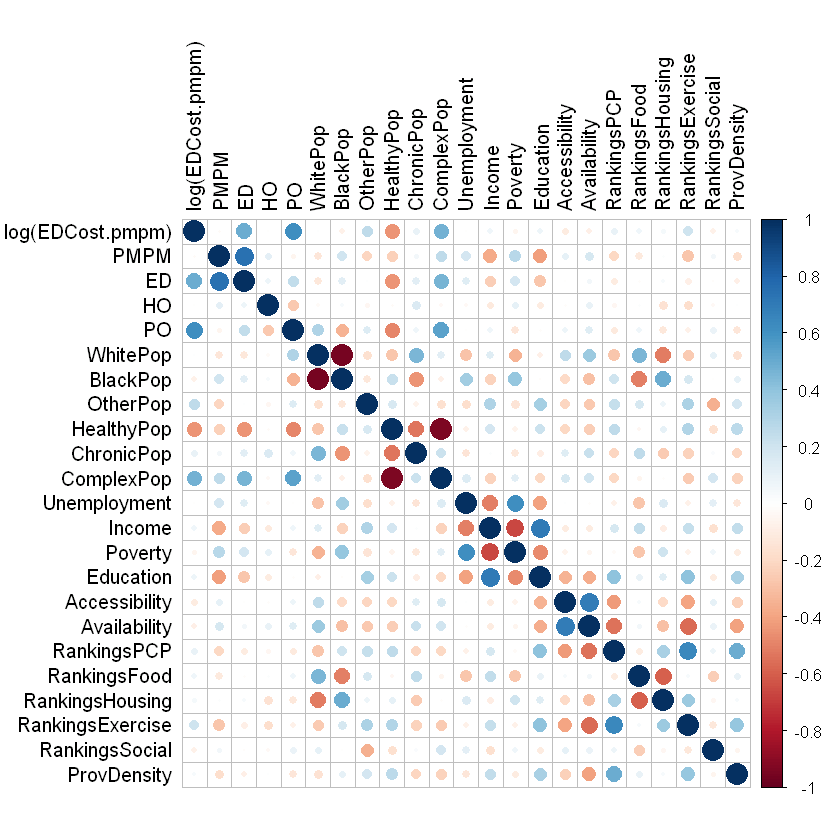

In [11]:
corr = cor(cbind(log(EDCost.pmpm), 
                 dataAdult[,-c(1, 2, 3, 18)]))
corrplot(corr, 
         tl.col="black")


We can see a large positive correlation between the response variable and the utilization of physician office and a large positive correlation between the response variable and the percentage of adults with complex conditions. We also see a large negative correlation between the response variable and the percentage of population that are considered healthy.

Among the predicting variables, we see a strong negative correlation between the percentage of black and percentage of white populations, and between percentage of adults that are considered healthy and percentage of adults with complex conditions. 

In [12]:
# Full model
# Exclude GEOID, scaling factor PMPM, and confounding factors EDCost and ED
# Exclude OtherPop & ComplexPop because of linear dependence
dataAdult.red = dataAdult[, -c(1, 3, 4, 5, 10, 13)] 

fullmodel = lm(log(EDCost.pmpm) ~ ., data=dataAdult.red)
summary(fullmodel)



Call:
lm(formula = log(EDCost.pmpm) ~ ., data = dataAdult.red)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14286 -0.13782  0.00008  0.13464  1.75586 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.208e+00  1.175e-01  18.788  < 2e-16 ***
StateAR             9.235e-01  1.610e-02  57.353  < 2e-16 ***
StateLA             9.081e-01  1.358e-02  66.853  < 2e-16 ***
StateNC             1.418e+00  1.650e-02  85.909  < 2e-16 ***
HO                  1.168e+01  7.587e-01  15.401  < 2e-16 ***
PO                  1.378e-01  4.114e-02   3.350 0.000815 ***
WhitePop            4.416e-03  5.800e-04   7.614 3.16e-14 ***
BlackPop            4.894e-03  5.824e-04   8.403  < 2e-16 ***
HealthyPop         -9.044e-04  8.160e-04  -1.108 0.267751    
ChronicPop         -5.949e-03  2.052e-03  -2.899 0.003760 ** 
Unemployment        4.390e-04  7.377e-04   0.595 0.551797    
Income             -2.556e-07  2.774e-07  -0.922 0.356769    
Poverty    

To fit the regression model, we will need to discard the GEOID, the PMPM scaling factor, the ED utilization, which is a confounding factor, and the percentage of Other population due to the linear dependence with the black and white population percentages. We also need to discard population percentages with complex health conditions due to the linear dependence with the percentage of adults with chronic conditions and of those who are relatively healthy. 

Regarding the full model, socioeconomic predicting variables including unemployment, median income, percentage of population below the poverty level, and rankings with respect to social environment, are not statistically significant given other predicting variables in the model.

The predicting variables included in the model explain approximately 84% of the variability in the reponse variable which is a large R squared for an observational study.

### Residual Analysis

In [13]:
# Residuals versus individual predicting variables 
full.resid = rstandard(fullmodel)
cook = cooks.distance(fullmodel)

,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
909,-9.5813441,0.05426619,0.215564937
1396,7.6555116,0.01185790,0.028969810
4736,0.8456224,0.10325807,0.003431018
4737,0.7985080,0.10823168,0.003224639


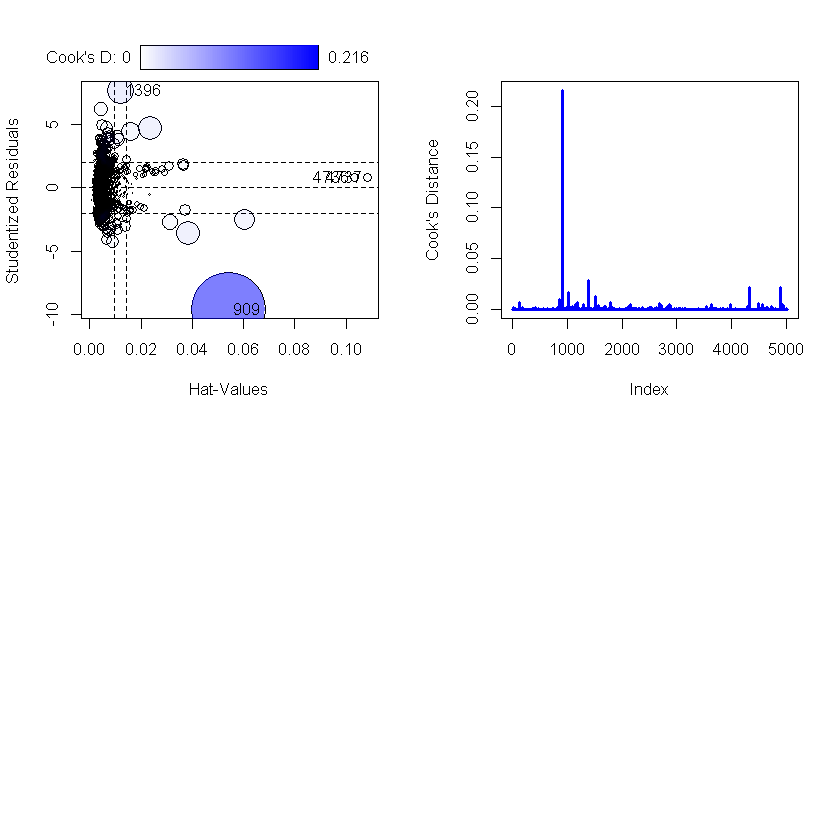

In [14]:
par(mfrow=c(2,2))
# Check outliers
influencePlot(fullmodel)
plot(cook, type="h", lwd=3, col="blue", ylab="Cook's Distance")

The influence plot is a bubble plot of the standardized residuals with areas of the circles being proportional to Cook’s distances. Both plots clearly show that point 909 is an outlier.

[1]  909 1396

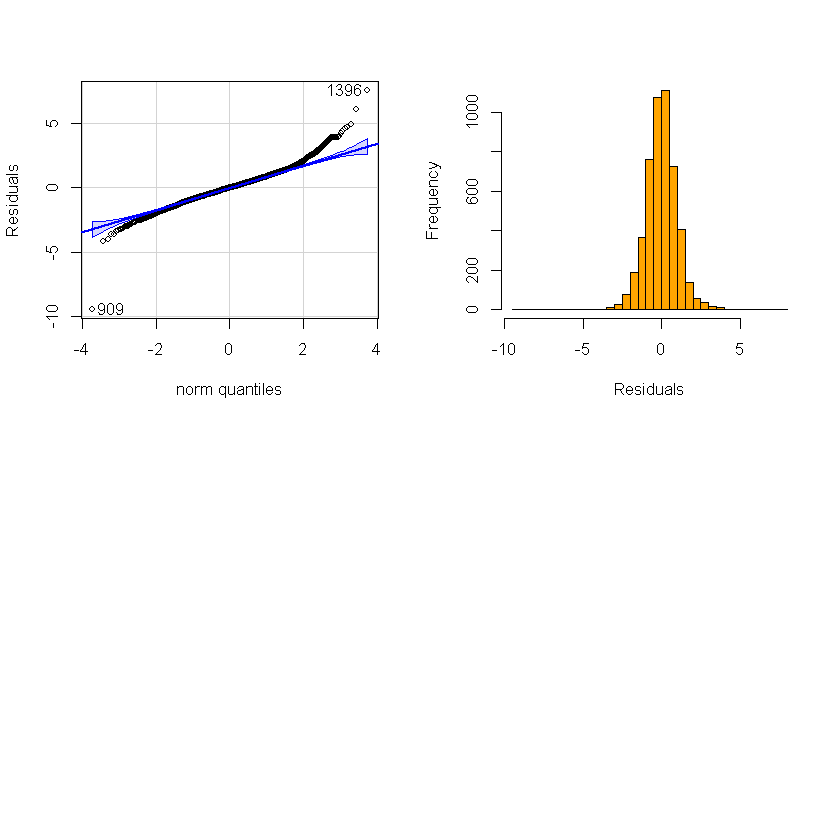

In [15]:
par(mfrow=c(2,2))
# Check Normality
qqPlot(full.resid, ylab="Residuals", main = "")
qqline(full.resid, col="blue", lwd=2)
hist(full.resid, xlab="Residuals", main = "", nclass=30, col="orange")

The distribution of the residuals is symmetric but with heavy tails, possibly, more of a T distribution than a normal distribution.

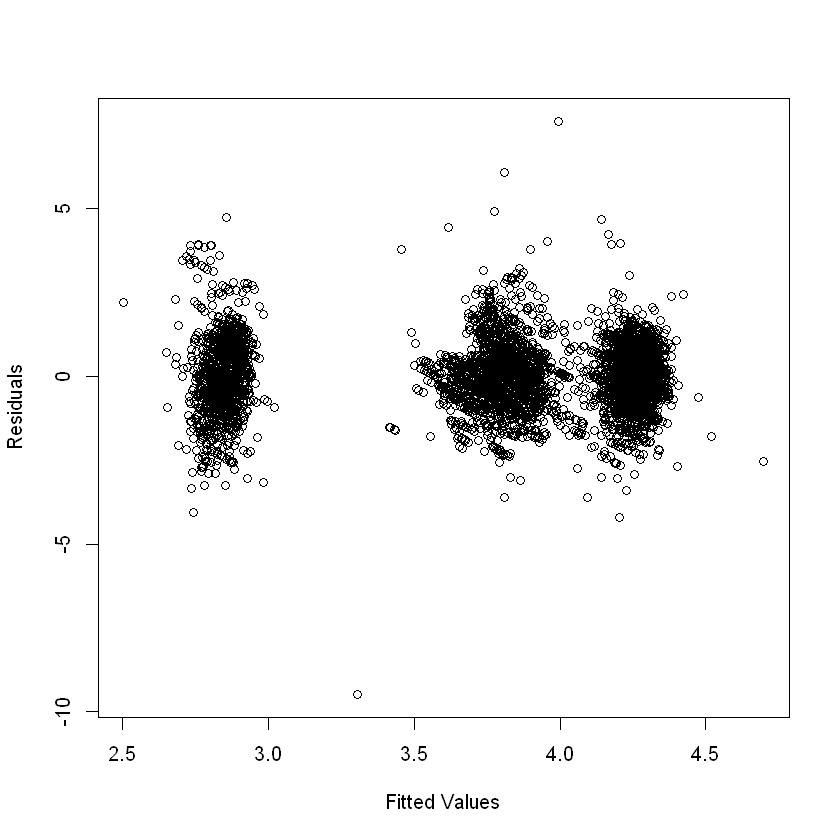

In [16]:
# Check Constant Variance & Uncorrelated Errors
full.fitted = fitted(fullmodel)
par(mfrow=c(1,1))
plot(full.fitted, full.resid, xlab="Fitted Values", ylab="Residuals")

We evaluate the assumptions of constant variance and uncorrelated errors. There is no evidence that the variance changes across the residuals. However, there are three clear clusters of the residuals pointing out to a possible departure from the uncorrelated errors assumption. 

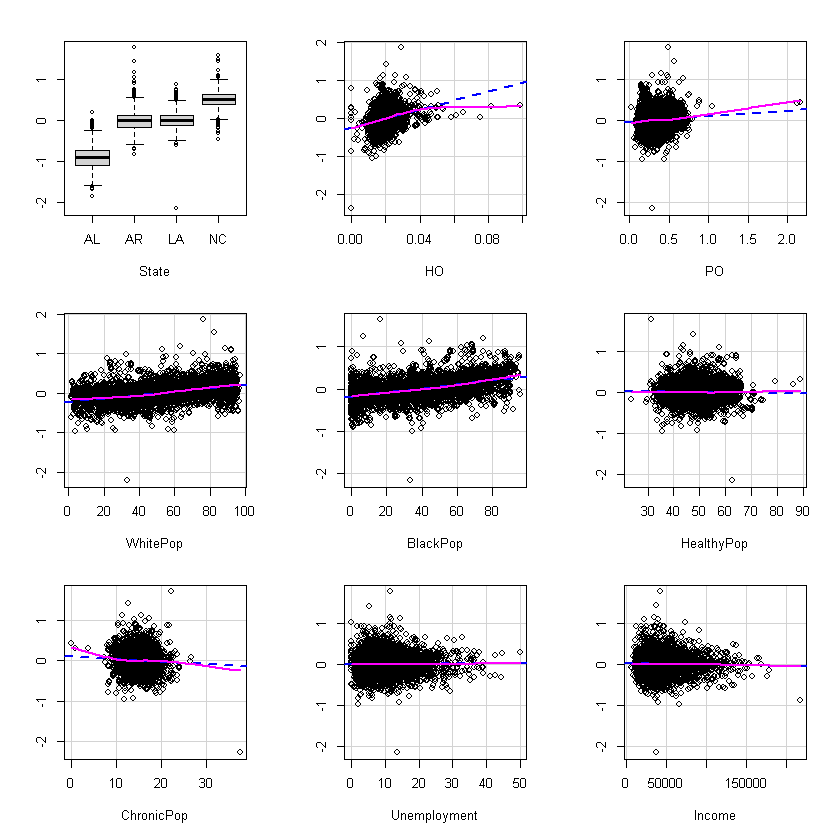

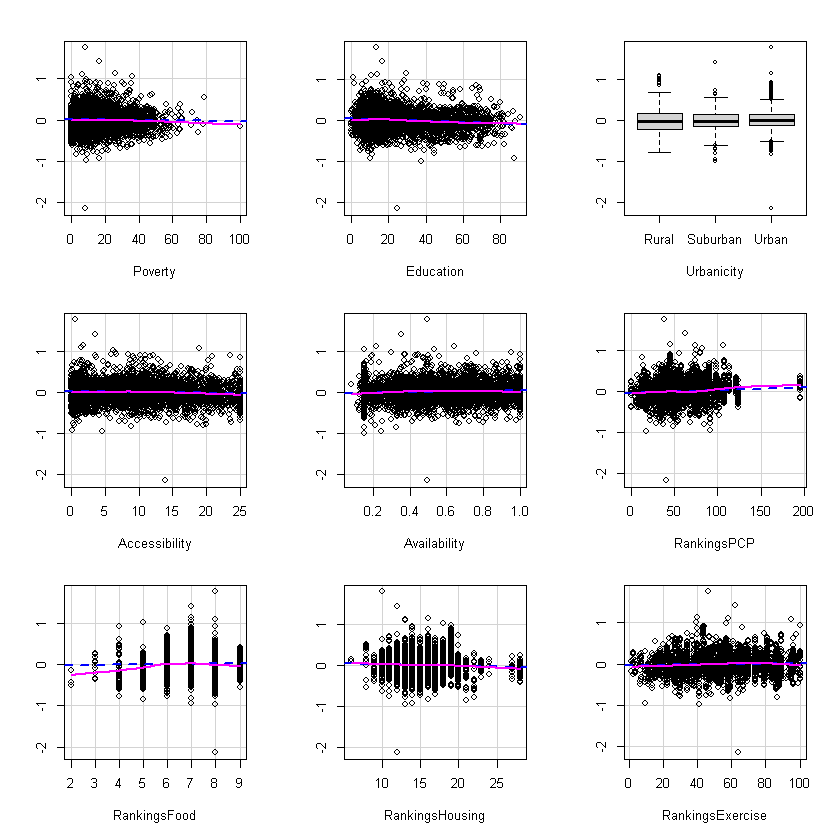

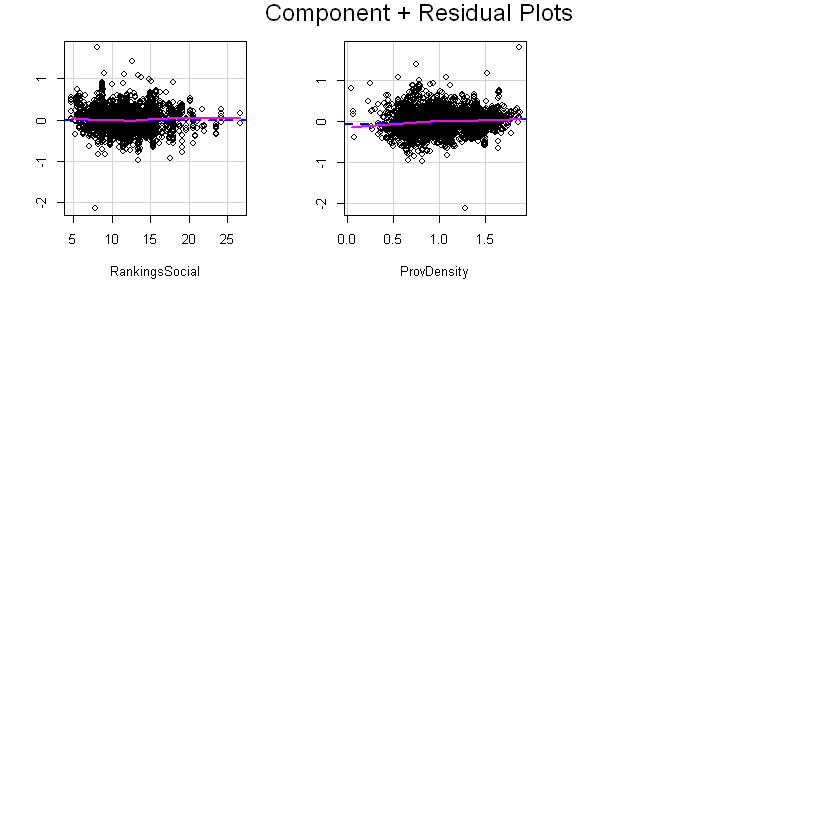

In [17]:
# Check Linearity
crPlots(fullmodel, ylab="", ask=FALSE)

This step is to check the linearity. We use boxplots for qualitative variables and scatterplots for quantitative variables.

Interpretation:
The boxplot of residuals vs. state shows some variation across the states but small variation among medians.

The scatterplot of hospitalization vs. residuals shows a slight increase in the trend, possibly due to the fact that there are a few large values in the inpatient utilization that pull the trend upwards. 

### VARIABLE SELECTION 

2^23 =  8388608 models -- not feasible to compare all models

In [18]:
# Apply Lasso Regression
set.seed(100)
predictors = as.matrix(dataAdult[, -c(1, 2, 3, 4, 5, 10, 13, 18)])

# Set up indicator (dummy) variables for State and Urbanicity
AL= rep(0, length(State)) ## Baseline
AL[as.numeric(factor(State))==1] = 1
AR = rep(0, length(State))
AR[as.numeric(factor(State))==2] = 1
LA = rep(0, length(State))
LA[as.numeric(factor(State))==3] = 1
NC = rep(0, length(State))
NC[as.numeric(factor(State))==4] = 1
rural   = rep(0, length(Urbanicity)) ## Baseline
rural[as.numeric(factor(Urbanicity))==1] = 1
suburban = rep(0, length(Urbanicity))
suburban[as.numeric(factor(Urbanicity))==2] = 1
urban    = rep(0, length(Urbanicity))
urban[as.numeric(factor(Urbanicity))==3] = 1
predictors = cbind(predictors, AR, LA, NC, suburban, urban)



The code above prepares the predicting variables for fitting the regularized regression model. In this code, we rename the dummy variables to reflect the categories within the corresponding categorical variable. We also discard one dummy variable for each qualitative predicting variable. 

For this study we have 23 predicting variables, which is equivalent to about 8 million combinations of submodels; that’s more than 8 million models to search through if we were to employ exhaustive search. Thus, we cannot fit all 8 million models and compare them to select the best model. We will have to perform either stepwise regression or regularized regression.

In [19]:
# 10-fold CV to find the optimal lambda 
lassomodel.cv = cv.glmnet(predictors, log(EDCost.pmpm), alpha=1, nfolds=10)

# Fit lasso model with 100 values for lambda
lassomodel = glmnet(predictors, log(EDCost.pmpm), alpha=1, nlambda=100)

Here we are using alpha =1 and 10 cross-fold to fit the LASSO regression model.

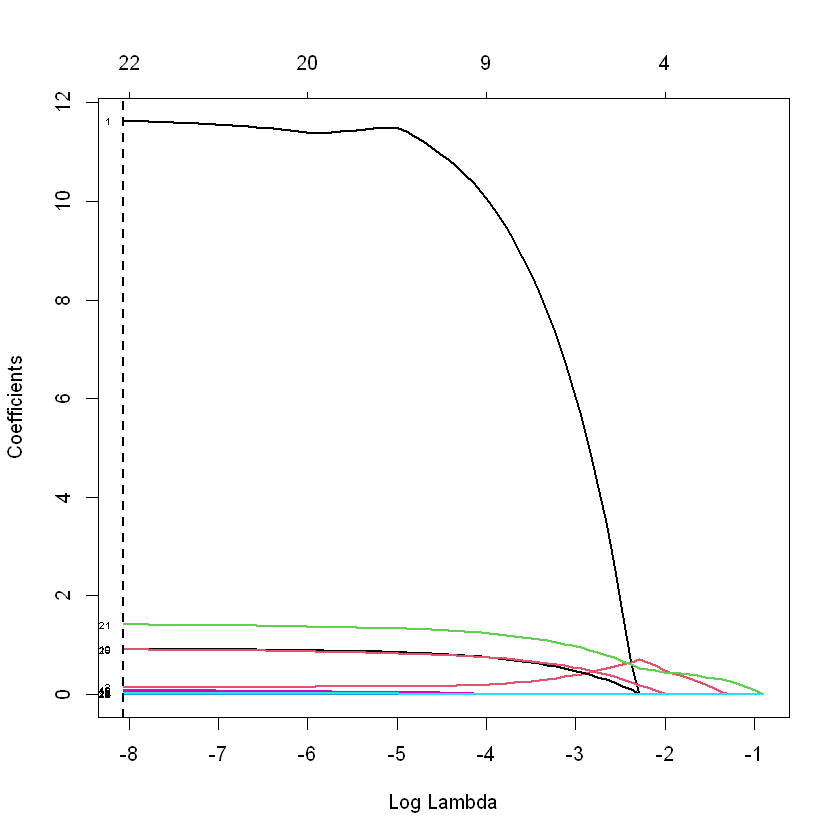

In [20]:
# Plot coefficient paths
plot(lassomodel, xvar="lambda", label=TRUE, lwd=2)
abline(v=log(lassomodel.cv$lambda.min), col='black', lty=2, lwd=2)

The vertical line in the path plot corresponds to the optimal lambdas, suggesting the selection of 22 out of 23 predicting variables.

Among the coefficient paths that stand out, the black line corresponds to the first variable in the matrix of the predicting variables, which corresponds to inpatient care utilization. Urbanicity dummy variables were selected but have low coefficient paths. 

In [21]:
# Extract coefficients at optimal lambda
coef(lassomodel, lassomodel.cv$lambda.min)

24 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)       2.277008e+00
HO                1.162649e+01
PO                1.389343e-01
WhitePop          3.767074e-03
BlackPop          4.246413e-03
HealthyPop       -1.042170e-03
ChronicPop       -5.704991e-03
Unemployment      3.421637e-04
Income           -2.307290e-07
Poverty          -2.383079e-04
Education        -1.451700e-03
Accessibility    -1.831102e-03
Availability      7.664592e-02
RankingsPCP       7.194696e-04
RankingsFood      5.782113e-03
RankingsHousing  -4.587208e-03
RankingsExercise  3.969711e-04
RankingsSocial    .           
ProvDensity       5.923880e-02
AR                9.183680e-01
LA                9.027530e-01
NC                1.410464e+00
suburban         -7.302044e-05
urban             2.096038e-02

22 out of 23 predicting variables are selected at the optimal lambda.

In [22]:
# Elastic Net
# 10-fold CV to find the optimal lambda 
enetmodel.cv = cv.glmnet(predictors, log(EDCost.pmpm), alpha=0.5, nfolds=10)

# Fit elastic net model with 100 values for lambda
enetmodel = glmnet(predictors, log(EDCost.pmpm), alpha=0.5, nlambda=100)


We use a similar implementation for the more general variable selection approach, the Elastic Net. The only difference is the specification of alpha which is set to be equal to 0.5. The alpha equal to 0.5 means that we are giving equal weights to the two penalties, the L2 or the Ridge regression penalty and the L1 or the LASSO penalty.

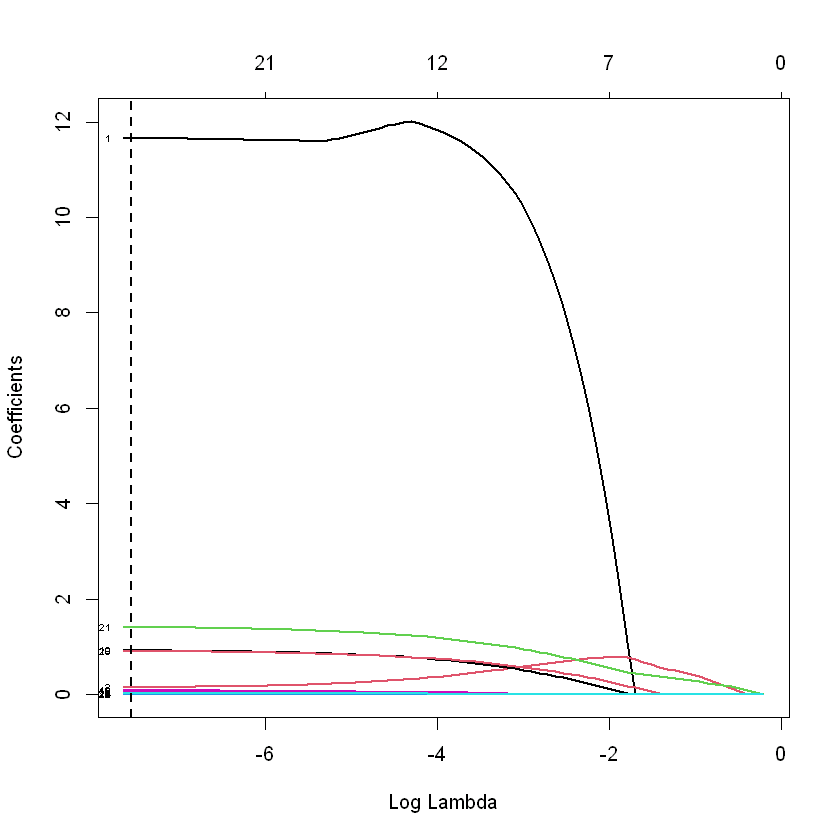

In [23]:
## Plot coefficient paths
plot(enetmodel, xvar="lambda", label=TRUE, lwd=2)
abline(v=log(enetmodel.cv$lambda.min), col='black', lty=2, lwd=2)

High coefficients paths are similar to those for LASSO. 

In [24]:
# Extract coefficients at optimal lambda
coef(enetmodel, s=enetmodel.cv$lambda.min)

24 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)       2.281834e+00
HO                1.165839e+01
PO                1.470070e-01
WhitePop          3.740041e-03
BlackPop          4.235162e-03
HealthyPop       -1.150550e-03
ChronicPop       -5.787252e-03
Unemployment      3.645349e-04
Income           -2.378440e-07
Poverty          -2.711813e-04
Education        -1.451883e-03
Accessibility    -1.869853e-03
Availability      7.735958e-02
RankingsPCP       7.195706e-04
RankingsFood      6.024685e-03
RankingsHousing  -4.572583e-03
RankingsExercise  4.202769e-04
RankingsSocial    .           
ProvDensity       5.948301e-02
AR                9.148418e-01
LA                9.004042e-01
NC                1.405599e+00
suburban         -3.432797e-04
urban             2.107438e-02

Similar to LASSO, we select 22 variables out of 23 with RankingsSocial being discarded from the model.

### Apply Stepwise Regression

In [25]:
full = lm(log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + Urbanicity + HO + PO +
              BlackPop + WhitePop + Unemployment + Income + Poverty+ Education +
              Accessibility + Availability + ProvDensity +
              RankingsPCP + RankingsFood + RankingsExercise + RankingsSocial, data=dataAdult)  
minimum = lm(log(EDCost.pmpm) ~ HealthyPop + ChronicPop, data=dataAdult)

The minimum model includes only the two controlling variables. 

In [26]:
# Forward Stepwise Regression
forward.model = step(minimum, scope=list(lower=minimum, upper=full), direction="forward")
summary(forward.model)

Start:  AIC=-6508.82
log(EDCost.pmpm) ~ HealthyPop + ChronicPop

                   Df Sum of Sq     RSS      AIC
+ State             3   1072.51  298.02 -14160.8
+ PO                1    321.40 1049.14  -7848.1
+ RankingsExercise  1    203.59 1166.94  -7313.9
+ RankingsPCP       1     68.73 1301.81  -6765.0
+ Accessibility     1     64.72 1305.82  -6749.6
+ Urbanicity        2     61.31 1309.22  -6734.5
+ Availability      1     56.64 1313.90  -6718.6
+ Income            1     56.10 1314.43  -6716.6
+ Education         1     53.76 1316.77  -6707.7
+ RankingsSocial    1     49.80 1320.73  -6692.6
+ ProvDensity       1     37.63 1332.90  -6646.6
+ Poverty           1     25.98 1344.55  -6602.9
+ RankingsFood      1     17.84 1352.70  -6572.6
+ Unemployment      1     11.70 1358.84  -6549.8
+ WhitePop          1      5.95 1364.58  -6528.7
+ BlackPop          1      4.04 1366.49  -6521.6
<none>                          1370.53  -6508.8
+ HO                1      0.40 1370.13  -6508.3

Ste


Call:
lm(formula = log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + 
    HO + Education + ProvDensity + RankingsPCP + Availability + 
    Accessibility + PO + Urbanicity + BlackPop + WhitePop + RankingsFood, 
    data = dataAdult)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1289 -0.1372 -0.0007  0.1376  1.7608 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.0271089  0.0995378  20.365  < 2e-16 ***
HealthyPop         -0.0005092  0.0007837  -0.650 0.515917    
ChronicPop         -0.0051250  0.0020252  -2.531 0.011418 *  
StateAR             0.9324593  0.0155667  59.901  < 2e-16 ***
StateLA             0.9003846  0.0118631  75.898  < 2e-16 ***
StateNC             1.4268425  0.0157605  90.533  < 2e-16 ***
HO                 12.0476486  0.7237072  16.647  < 2e-16 ***
Education          -0.0016689  0.0002312  -7.218 6.08e-13 ***
ProvDensity         0.0605923  0.0156154   3.880 0.000106 ***
RankingsPCP         0.0007885  0.00

In [27]:
# Backward Stepwise Regression
backward.model = step(full, scope=list(lower=minimum, upper=full), direction = "backward")
summary(backward.model)

Start:  AIC=-14632.41
log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + Urbanicity + 
    HO + PO + BlackPop + WhitePop + Unemployment + Income + Poverty + 
    Education + Accessibility + Availability + ProvDensity + 
    RankingsPCP + RankingsFood + RankingsExercise + RankingsSocial

                   Df Sum of Sq    RSS      AIC
- RankingsSocial    1      0.00 269.46 -14634.4
- Income            1      0.02 269.48 -14634.1
- Unemployment      1      0.02 269.48 -14634.1
- Poverty           1      0.04 269.50 -14633.7
- RankingsExercise  1      0.05 269.51 -14633.4
<none>                          269.46 -14632.4
- Urbanicity        2      0.30 269.76 -14630.8
- Accessibility     1      0.46 269.91 -14625.9
- PO                1      0.52 269.98 -14624.7
- RankingsFood      1      0.76 270.22 -14620.3
- RankingsPCP       1      0.82 270.28 -14619.2
- ProvDensity       1      0.85 270.31 -14618.6
- Availability      1      0.90 270.36 -14617.6
- Education         1      1.33 270.79


Call:
lm(formula = log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + 
    Urbanicity + HO + PO + BlackPop + WhitePop + Education + 
    Accessibility + Availability + ProvDensity + RankingsPCP + 
    RankingsFood, data = dataAdult)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1289 -0.1372 -0.0007  0.1376  1.7608 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.0271089  0.0995378  20.365  < 2e-16 ***
HealthyPop         -0.0005092  0.0007837  -0.650 0.515917    
ChronicPop         -0.0051250  0.0020252  -2.531 0.011418 *  
StateAR             0.9324593  0.0155667  59.901  < 2e-16 ***
StateLA             0.9003846  0.0118631  75.898  < 2e-16 ***
StateNC             1.4268425  0.0157605  90.533  < 2e-16 ***
UrbanicitySuburban -0.0017746  0.0136754  -0.130 0.896758    
UrbanicityUrban     0.0226383  0.0124409   1.820 0.068870 .  
HO                 12.0476486  0.7237072  16.647  < 2e-16 ***
PO                  0.1232428  0.04

In [28]:
# Forward-Backward Stepwise Regression
both.min.model = step(minimum, scope=list(lower=minimum, upper=full), direction = "both")
summary(both.min.model)

Start:  AIC=-6508.82
log(EDCost.pmpm) ~ HealthyPop + ChronicPop

                   Df Sum of Sq     RSS      AIC
+ State             3   1072.51  298.02 -14160.8
+ PO                1    321.40 1049.14  -7848.1
+ RankingsExercise  1    203.59 1166.94  -7313.9
+ RankingsPCP       1     68.73 1301.81  -6765.0
+ Accessibility     1     64.72 1305.82  -6749.6
+ Urbanicity        2     61.31 1309.22  -6734.5
+ Availability      1     56.64 1313.90  -6718.6
+ Income            1     56.10 1314.43  -6716.6
+ Education         1     53.76 1316.77  -6707.7
+ RankingsSocial    1     49.80 1320.73  -6692.6
+ ProvDensity       1     37.63 1332.90  -6646.6
+ Poverty           1     25.98 1344.55  -6602.9
+ RankingsFood      1     17.84 1352.70  -6572.6
+ Unemployment      1     11.70 1358.84  -6549.8
+ WhitePop          1      5.95 1364.58  -6528.7
+ BlackPop          1      4.04 1366.49  -6521.6
<none>                          1370.53  -6508.8
+ HO                1      0.40 1370.13  -6508.3

Ste


Call:
lm(formula = log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + 
    HO + Education + ProvDensity + RankingsPCP + Availability + 
    Accessibility + PO + Urbanicity + BlackPop + WhitePop + RankingsFood, 
    data = dataAdult)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1289 -0.1372 -0.0007  0.1376  1.7608 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.0271089  0.0995378  20.365  < 2e-16 ***
HealthyPop         -0.0005092  0.0007837  -0.650 0.515917    
ChronicPop         -0.0051250  0.0020252  -2.531 0.011418 *  
StateAR             0.9324593  0.0155667  59.901  < 2e-16 ***
StateLA             0.9003846  0.0118631  75.898  < 2e-16 ***
StateNC             1.4268425  0.0157605  90.533  < 2e-16 ***
HO                 12.0476486  0.7237072  16.647  < 2e-16 ***
Education          -0.0016689  0.0002312  -7.218 6.08e-13 ***
ProvDensity         0.0605923  0.0156154   3.880 0.000106 ***
RankingsPCP         0.0007885  0.00

The variables not selected by all stepwise regression methods are unemployment, income, poverty, and county ranking by exercise. Forward stepwise regression selects one more variable, RankingsSocial. These are also predicting variables that were not statistically significant in the full model. 

The model explains 85% of the variability in the ED cost. The dummy variable corresponding to suburban communities versus rural communities (the baseline) is not statistically significant although it has been selected by stepwise regression. Similarly, the dummy variable corresponding to the urban dummy variable is not statistically significant at 0.05 because the p-value is 0.06. Recall that we tested whether the urbanicity qualitative variable should be included in the full model, concluding that the model without this categorical variable performs similarly to the full model.

Access measures remain statistically significantly associated to log of ED healthcare cost. Both measures were selected by stepwise regression. 


In [29]:
# Compare full model to selected model
reg.step = lm(log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State +  Urbanicity + HO       
           + PO + BlackPop + WhitePop + Education +  Accessibility + Availability 
           + ProvDensity + RankingsPCP + RankingsFood, ,data=dataAdult)

anova(reg.step, full)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5001,269.5634,NA,NA,NA,NA
2,4996,269.4593,5,0.1040613,0.3858767,0.8587993


We compare the full model versus the reduced model including only the variables selected by stepwise regression using the partial F-test. The p-value of the test is large, indicating that we do not reject the null hypothesis corresponding to the reduced model. Thus, we conclude that the reduced model plausibly performs similarly in terms of explanatory power as the full model. We prefer the reduced model because it includes a smaller number of predicting variables.

###  Residual Analysis for Selected Model 

[1]  909 1396

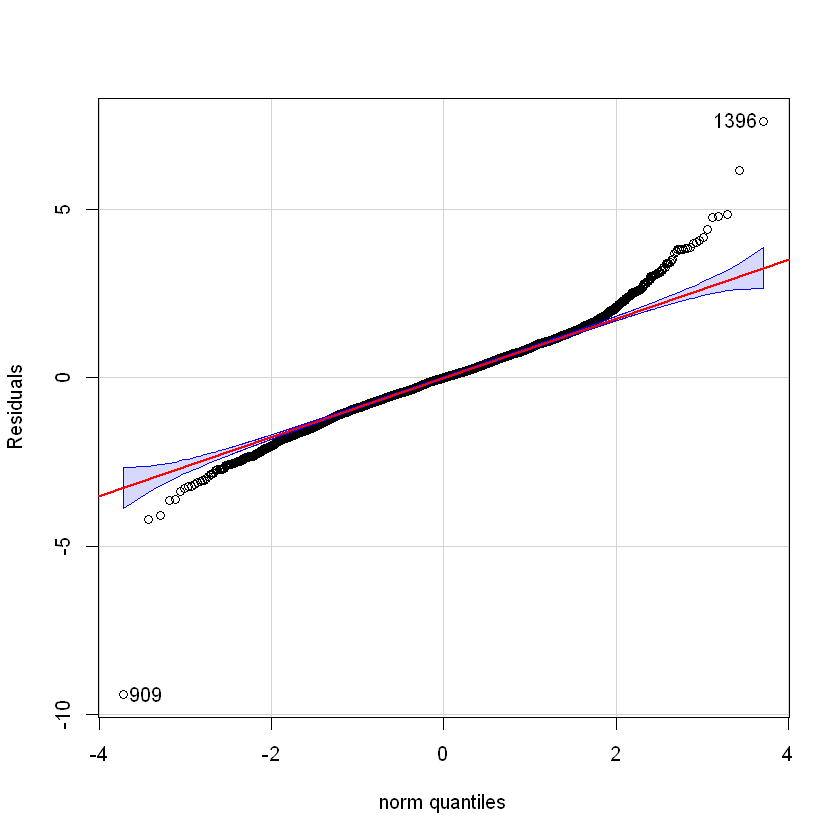

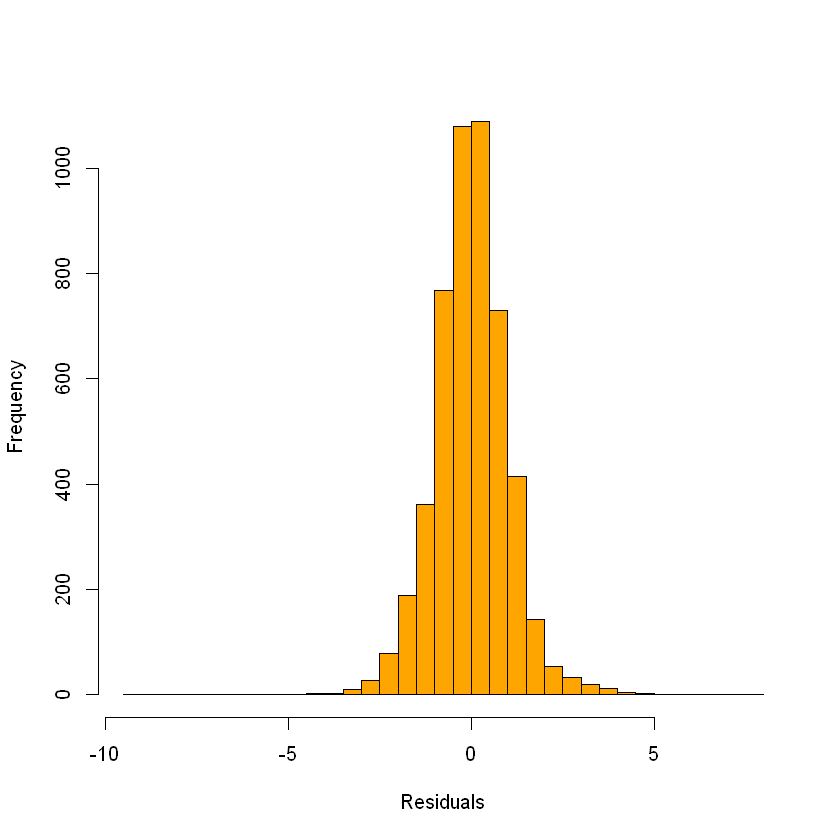

In [30]:
red.resid = rstandard(reg.step)
red.cook = cooks.distance(reg.step)

# Check normality
qqPlot(red.resid, ylab="Residuals", main = "")
qqline(red.resid, col="red", lwd=2)
hist(red.resid, xlab="Residuals", main = "", nclass=30, col="orange")

The plots show the shape of the distribution of the residuals and that the distribution is symmetric, but with heavy tails similar to the full model.

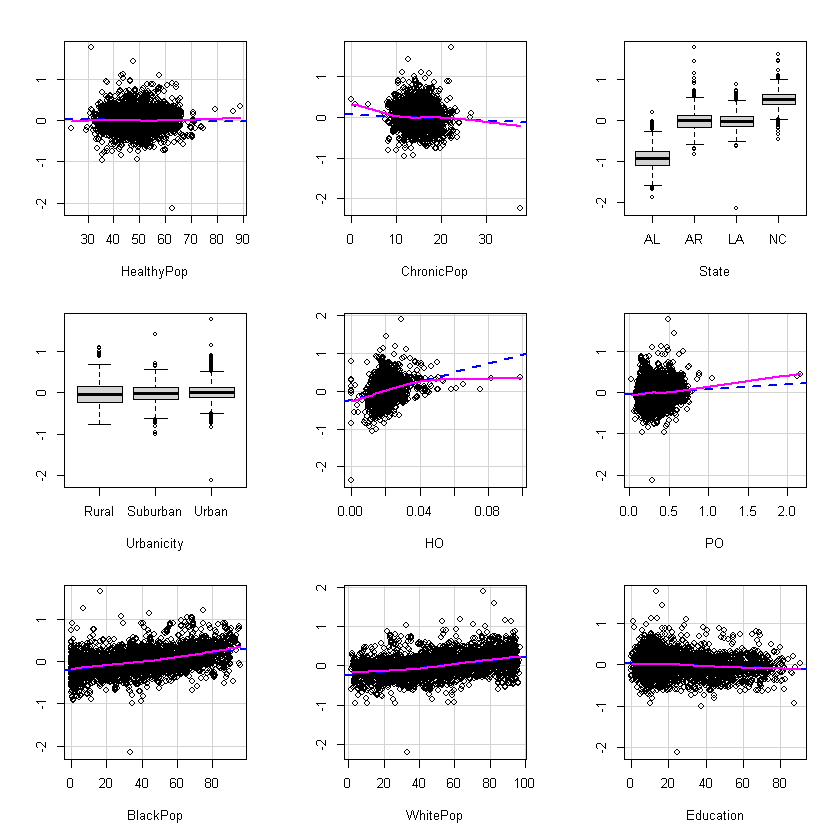

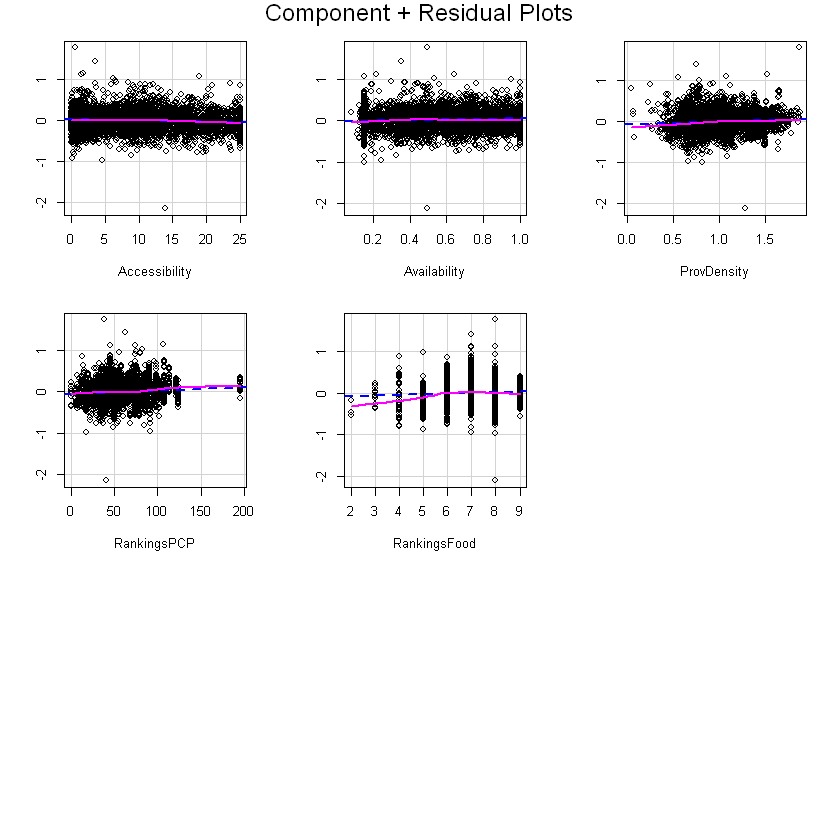

In [31]:
# Check Linearity
crPlots(reg.step,ylab="", ask=FALSE)

There are no substantial differences in the diagnostics for linearity for the selected model versus the full model.

In [32]:
# Remove OUtlier
dataAdult.no.out = dataAdult[-909,]
EDCost.pmpm.no.out = EDCost.pmpm[-909]

full.no.out = lm(log(EDCost.pmpm.no.out) ~ HealthyPop + ChronicPop + State + Urbanicity +
                     HO + PO + BlackPop + WhitePop + Unemployment + Income + Poverty +
                     Education + Accessibility + Availability + ProvDensity + RankingsPCP +
                     RankingsFood + RankingsExercise + RankingsSocial, data=dataAdult.no.out)

minimum.no.out = lm(log(EDCost.pmpm.no.out) ~ HealthyPop+ChronicPop, data=dataAdult.no.out)

In [33]:
# Backward Stepwise Regression
backward.model.no.out = step(full.no.out, scope=list(lower=minimum.no.out,
                             upper=full.no.out), direction="backward")
summary(backward.model.no.out)

Start:  AIC=-14719
log(EDCost.pmpm.no.out) ~ HealthyPop + ChronicPop + State + Urbanicity + 
    HO + PO + BlackPop + WhitePop + Unemployment + Income + Poverty + 
    Education + Accessibility + Availability + ProvDensity + 
    RankingsPCP + RankingsFood + RankingsExercise + RankingsSocial

                   Df Sum of Sq    RSS      AIC
- RankingsSocial    1      0.00 264.64 -14721.0
- Unemployment      1      0.03 264.67 -14720.4
- RankingsExercise  1      0.04 264.68 -14720.2
- Income            1      0.05 264.69 -14720.1
- Poverty           1      0.05 264.69 -14720.1
<none>                          264.64 -14719.0
- Urbanicity        2      0.29 264.93 -14717.6
- Accessibility     1      0.39 265.03 -14713.6
- PO                1      0.62 265.26 -14709.3
- RankingsPCP       1      0.75 265.39 -14706.9
- RankingsFood      1      0.81 265.45 -14705.6
- Availability      1      0.91 265.55 -14703.8
- ProvDensity       1      1.00 265.64 -14702.1
- Education         1      1.25 26


Call:
lm(formula = log(EDCost.pmpm.no.out) ~ HealthyPop + ChronicPop + 
    State + Urbanicity + HO + PO + BlackPop + WhitePop + Education + 
    Accessibility + Availability + ProvDensity + RankingsPCP + 
    RankingsFood, data = dataAdult.no.out)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95424 -0.13902 -0.00161  0.13653  1.74621 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.9356344  0.0991296  19.526  < 2e-16 ***
HealthyPop          0.0003798  0.0007824   0.485 0.627430    
ChronicPop         -0.0010849  0.0020519  -0.529 0.597031    
StateAR             0.9379139  0.0154403  60.745  < 2e-16 ***
StateLA             0.8989533  0.0117596  76.444  < 2e-16 ***
StateNC             1.4282364  0.0156224  91.422  < 2e-16 ***
UrbanicitySuburban -0.0006647  0.0135555  -0.049 0.960895    
UrbanicityUrban     0.0222961  0.0123314   1.808 0.070654 .  
HO                 11.5397384  0.7193214  16.043  < 2e-16 ***
PO         

In [34]:
summary(backward.model)


Call:
lm(formula = log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + 
    Urbanicity + HO + PO + BlackPop + WhitePop + Education + 
    Accessibility + Availability + ProvDensity + RankingsPCP + 
    RankingsFood, data = dataAdult)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1289 -0.1372 -0.0007  0.1376  1.7608 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.0271089  0.0995378  20.365  < 2e-16 ***
HealthyPop         -0.0005092  0.0007837  -0.650 0.515917    
ChronicPop         -0.0051250  0.0020252  -2.531 0.011418 *  
StateAR             0.9324593  0.0155667  59.901  < 2e-16 ***
StateLA             0.9003846  0.0118631  75.898  < 2e-16 ***
StateNC             1.4268425  0.0157605  90.533  < 2e-16 ***
UrbanicitySuburban -0.0017746  0.0136754  -0.130 0.896758    
UrbanicityUrban     0.0226383  0.0124409   1.820 0.068870 .  
HO                 12.0476486  0.7237072  16.647  < 2e-16 ***
PO                  0.1232428  0.04

There are no large differences when comparing the selected models using backward stepwise regression with versus without the outlier 909. The R-squares remain around 85%. The only difference is that ChronicPop becomes statistically insignificant without the outlier.

In [35]:
reg.step.no.out = lm(log(EDCost.pmpm.no.out) ~ HealthyPop + ChronicPop + State + HO +
                         Education + ProvDensity + RankingsPCP + Accessibility +
                         Availability + PO + Urbanicity + BlackPop + WhitePop +
                         RankingsFood, data=dataAdult.no.out)

In [36]:
# NOT IN VIDEO
summary(reg.step.no.out) # gives same results as summary(backward.model.no.out) above
summary(reg.step) # gives same results as summary(backward.model) above
# END NOT IN VIDEO


Call:
lm(formula = log(EDCost.pmpm.no.out) ~ HealthyPop + ChronicPop + 
    State + HO + Education + ProvDensity + RankingsPCP + Accessibility + 
    Availability + PO + Urbanicity + BlackPop + WhitePop + RankingsFood, 
    data = dataAdult.no.out)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95424 -0.13902 -0.00161  0.13653  1.74621 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.9356344  0.0991296  19.526  < 2e-16 ***
HealthyPop          0.0003798  0.0007824   0.485 0.627430    
ChronicPop         -0.0010849  0.0020519  -0.529 0.597031    
StateAR             0.9379139  0.0154403  60.745  < 2e-16 ***
StateLA             0.8989533  0.0117596  76.444  < 2e-16 ***
StateNC             1.4282364  0.0156224  91.422  < 2e-16 ***
HO                 11.5397384  0.7193214  16.043  < 2e-16 ***
Education          -0.0017147  0.0002292  -7.480 8.72e-14 ***
ProvDensity         0.0654339  0.0154862   4.225 2.43e-05 ***
RankingsPCP


Call:
lm(formula = log(EDCost.pmpm) ~ HealthyPop + ChronicPop + State + 
    Urbanicity + HO + PO + BlackPop + WhitePop + Education + 
    Accessibility + Availability + ProvDensity + RankingsPCP + 
    RankingsFood, data = dataAdult)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1289 -0.1372 -0.0007  0.1376  1.7608 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.0271089  0.0995378  20.365  < 2e-16 ***
HealthyPop         -0.0005092  0.0007837  -0.650 0.515917    
ChronicPop         -0.0051250  0.0020252  -2.531 0.011418 *  
StateAR             0.9324593  0.0155667  59.901  < 2e-16 ***
StateLA             0.9003846  0.0118631  75.898  < 2e-16 ***
StateNC             1.4268425  0.0157605  90.533  < 2e-16 ***
UrbanicitySuburban -0.0017746  0.0136754  -0.130 0.896758    
UrbanicityUrban     0.0226383  0.0124409   1.820 0.068870 .  
HO                 12.0476486  0.7237072  16.647  < 2e-16 ***
PO                  0.1232428  0.04

The resulting regression models seem to present similar results.

### Prediction: Interventions

Recall one of the policy questions that we started this analysis with: Does improvement in availability of primary care providers reduce the cost of ED care? Based on this analysis, we found that access, particularly the availability measure, is statistically significantly associated to the ED healthcare cost. 

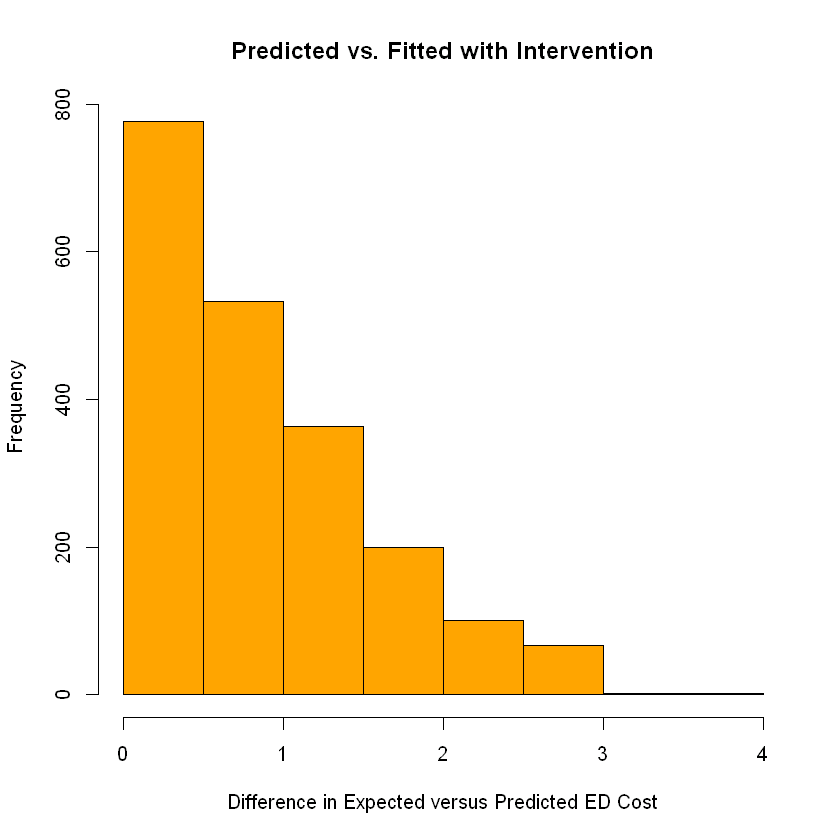

In [37]:
newdata=dataAdult.no.out
index = which(newdata$Availability >= 0.5)

# Improve Availability to at most 0.5 congestion experienced by all communities
newdata$Availability[index] = 0.5

# Predict by changing Availability with all other predictors fixed
EDCost.predict = predict(reg.step.no.out, newdata, interval="prediction")[,1]

# Compare predicted to fitted for those communities with intervention
EDCost.diff.fitted = exp(fitted(reg.step.no.out)) - exp(EDCost.predict)
hist(EDCost.diff.fitted[index], xlab="Difference in Expected versus Predicted ED Cost", 
     main="Predicted vs. Fitted with Intervention", col="orange")


To address this question, we will modify the values of the availability predictor while keeping all other variables unchanged. Specifically, for any values of availability greater than 0.5, we will replace them with 0.5. This adjustment simulates an intervention aimed at improving access to primary care in communities where availability is currently above 0.5, effectively reducing congestion and increasing provider availability. By making this change, we assume that these communities experience enhanced primary care access, leading to reduced wait times for appointments. After modifying the availability variable, we will create a new dataset where only this column is updated, while all other variables remain the same.

The histogram shows that the difference is always positive and for some communities the difference in cost is almost $3 per member, per month. For other communities, the difference in the cost is smaller than $1 per member, per month. While this doesn't sound large, if we multiply the cost with 12 to get the cost difference per year, and we multiply that with the number of adults within each census tract, the difference in the cost could be quite large. 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-40.6579  -4.7203   0.1906   2.2265   6.8203  83.2608 

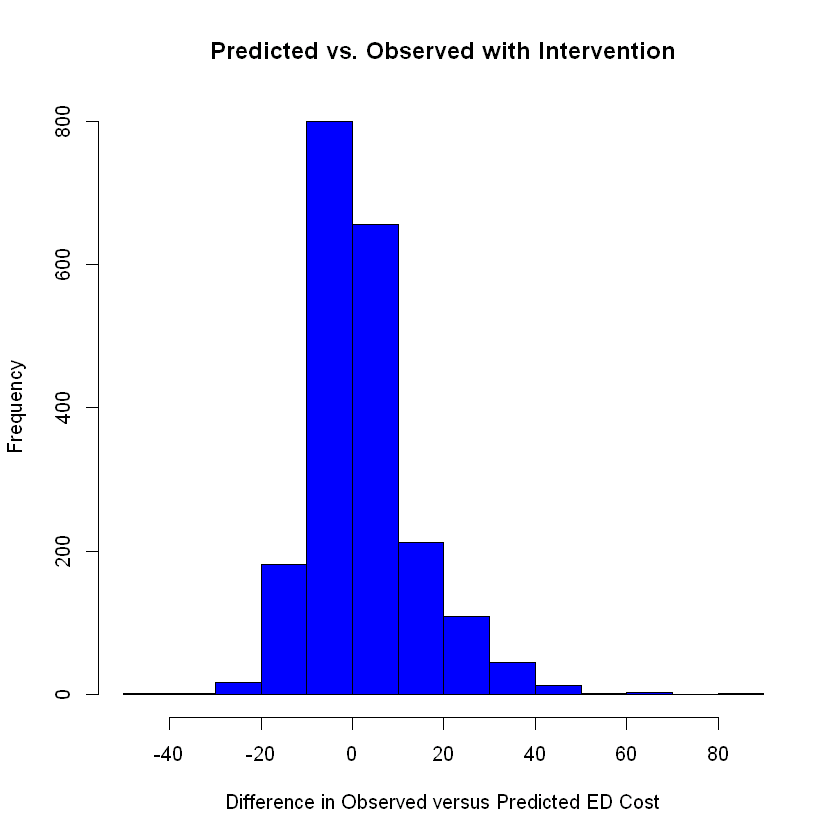

In [38]:
# Compare predicted to observed for those communities with intervention
EDCost.diff.observed = EDCost.pmpm[-909] - exp(EDCost.predict)
summary(EDCost.diff.observed[index])
hist(EDCost.diff.observed[index], xlab="Difference in Observed versus Predicted ED Cost", 
     main="Predicted vs. Observed with Intervention", col="blue")

We can see from the histogram in blue that we have both positive and negative differences; this is because the observed data are the expected response plus an error term; that error term makes some of the differences to be positive and others negative. We also see that there is a longer tail on the right, on the positive side, which says that there are more communities with a positive difference than with a negative difference.

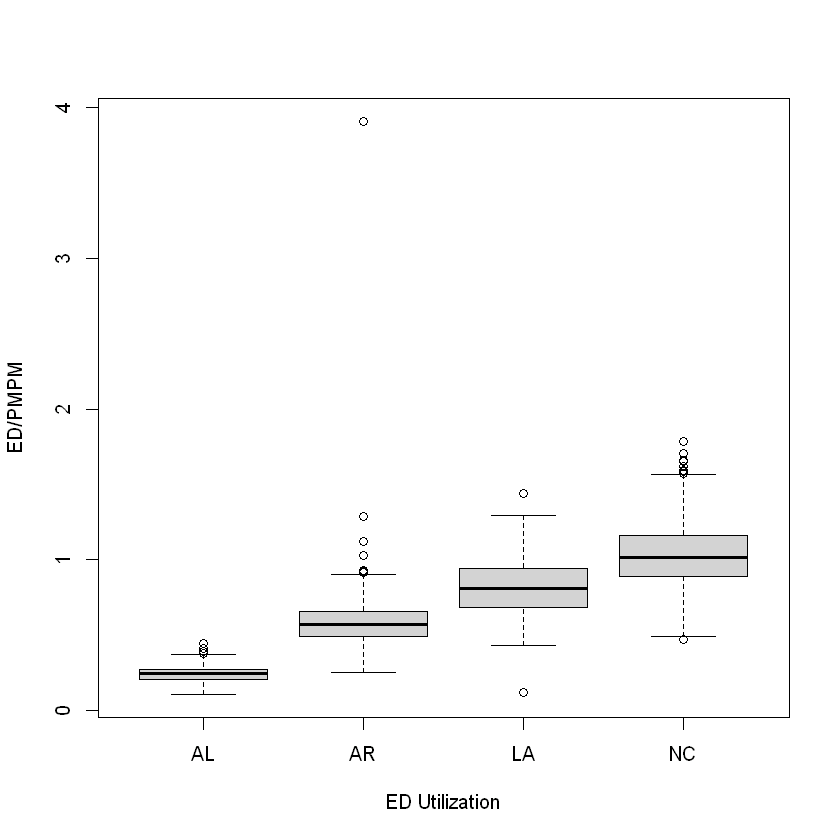

In [39]:
boxplot(ED/PMPM~State, xlab="ED Utilization")

Alabama has the lowest utilization level per adult and North Carolina has the highest utilization

In [40]:
# create a model without Urbanicity factors
data_less_urban = dataAdult.red[, -c(12)]
model_less_urban = lm(log(EDCost.pmpm) ~ ., 
                      data_less_urban)
summary(model_less_urban)


Call:
lm(formula = log(EDCost.pmpm) ~ ., data = data_less_urban)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14583 -0.13979  0.00072  0.13463  1.75797 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.202e+00  1.172e-01  18.781  < 2e-16 ***
StateAR           9.210e-01  1.592e-02  57.845  < 2e-16 ***
StateLA           9.091e-01  1.356e-02  67.038  < 2e-16 ***
StateNC           1.419e+00  1.646e-02  86.200  < 2e-16 ***
HO                1.163e+01  7.573e-01  15.363  < 2e-16 ***
PO                1.377e-01  4.060e-02   3.392 0.000699 ***
WhitePop          4.490e-03  5.791e-04   7.752 1.09e-14 ***
BlackPop          4.977e-03  5.811e-04   8.564  < 2e-16 ***
HealthyPop       -6.512e-04  8.072e-04  -0.807 0.419846    
ChronicPop       -5.948e-03  2.047e-03  -2.905 0.003683 ** 
Unemployment      4.718e-04  7.376e-04   0.640 0.522451    
Income           -2.166e-07  2.768e-07  -0.782 0.434023    
Poverty          -3.536e-04  4.460e

We explore the impact of urbanicity factor by creating the model without urbanicity and then perform the F-test between full model and model without urbanicity.

In [41]:
# conduct f test of two models: full model and model without urbanicity factors
anova(fullmodel,
      model_less_urban)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4995,268.9835,NA,NA,NA,NA
2,4997,269.2295,-2,-0.2459748,2.283865,0.101996


We fail to reject the null hypothesis and cannot show that the model including 
Urbanicity has explanatory power greater than the model without.

In [42]:
# look at the model to see which predictors are not statistically significant
# at *alpha* = 0.05
summary(fullmodel)


Call:
lm(formula = log(EDCost.pmpm) ~ ., data = dataAdult.red)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14286 -0.13782  0.00008  0.13464  1.75586 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.208e+00  1.175e-01  18.788  < 2e-16 ***
StateAR             9.235e-01  1.610e-02  57.353  < 2e-16 ***
StateLA             9.081e-01  1.358e-02  66.853  < 2e-16 ***
StateNC             1.418e+00  1.650e-02  85.909  < 2e-16 ***
HO                  1.168e+01  7.587e-01  15.401  < 2e-16 ***
PO                  1.378e-01  4.114e-02   3.350 0.000815 ***
WhitePop            4.416e-03  5.800e-04   7.614 3.16e-14 ***
BlackPop            4.894e-03  5.824e-04   8.403  < 2e-16 ***
HealthyPop         -9.044e-04  8.160e-04  -1.108 0.267751    
ChronicPop         -5.949e-03  2.052e-03  -2.899 0.003760 ** 
Unemployment        4.390e-04  7.377e-04   0.595 0.551797    
Income             -2.556e-07  2.774e-07  -0.922 0.356769    
Poverty    

In [43]:
# find which predictors are not statistically significant at *alpha* = 0.05
# and their corresponding p-values
summary(fullmodel)$coefficients[c(which(summary(fullmodel)$coefficients[ , 4] > 0.05)) , 4]

HealthyPop       Unemployment             Income            Poverty 
        0.26775092         0.55179706         0.35676905         0.45852859 
UrbanicitySuburban    UrbanicityUrban       RankingsFood   RankingsExercise 
        0.97340605         0.10335563         0.20564247         0.08690651 
    RankingsSocial 
        0.77249733

We list the coefficients which are not statistially significant at level of 0.05 according to their p-values.

In [44]:
colnames(dataAdult)

[1] "GEOID"            "State"            "EDCost"           "PMPM"            
 [5] "ED"               "HO"               "PO"               "WhitePop"        
 [9] "BlackPop"         "OtherPop"         "HealthyPop"       "ChronicPop"      
[13] "ComplexPop"       "Unemployment"     "Income"           "Poverty"         
[17] "Education"        "Urbanicity"       "Accessibility"    "Availability"    
[21] "RankingsPCP"      "RankingsFood"     "RankingsHousing"  "RankingsExercise"
[25] "RankingsSocial"   "ProvDensity"

In [45]:
data_less_not_stat_sig = dataAdult[, -c(1, 3, 4, 5, 10, 11, 13, 14, 15, 16, 18, 22, 24,25)] 
model_less_not_stat_sig = lm(log(EDCost.pmpm) ~ ., 
                             data = data_less_not_stat_sig)
summary(model_less_not_stat_sig)


Call:
lm(formula = log(EDCost.pmpm) ~ ., data = data_less_not_stat_sig)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.14815 -0.14199  0.00184  0.13583  1.78326 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.2323590  0.0625824  35.671  < 2e-16 ***
StateAR          0.9248715  0.0150227  61.565  < 2e-16 ***
StateLA          0.9236459  0.0120610  76.581  < 2e-16 ***
StateNC          1.4330007  0.0146808  97.610  < 2e-16 ***
HO              11.3323282  0.7371766  15.373  < 2e-16 ***
PO               0.1282729  0.0394940   3.248 0.001170 ** 
WhitePop         0.0044401  0.0005299   8.379  < 2e-16 ***
BlackPop         0.0047963  0.0005181   9.257  < 2e-16 ***
ChronicPop      -0.0059973  0.0017203  -3.486 0.000494 ***
Education       -0.0015695  0.0002296  -6.835 9.19e-12 ***
Accessibility   -0.0019221  0.0006957  -2.763 0.005749 ** 
Availability     0.0691197  0.0192023   3.600 0.000322 ***
RankingsPCP      0.0009065  0.0001604   5

In [46]:

# data_less_not_stat_sig = dataAdult[, -c(1, 3, 4, 5, 6, 8, 9, 10, 12, 13, 16, 18, 19)] 
# model_less_not_stat_sig = lm(log(EDCost.pmpm) ~ ., 
#                              data = data_less_not_stat_sig)
# summary(model_less_not_stat_sig)

Here we create a new model excluding the above predictors that are not statistically significant
and also exclude GEOID, scaling factor PMPM, and confounding factors EDCost and ED. We exclude OtherPop & ComplexPop because of linear dependence.

In [47]:
if (!require("CombMSC", character.only=TRUE)) {
packageurl <- "https://cran.r-project.org/src/contrib/Archive/CombMSC/CombMSC_1.4.2.1.tar.gz"
install.packages(packageurl, repos=NULL, type="source")
library(CombMSC)
}


Loading required package: CombMSC

Installing package into 'C:/Users/david/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)


Attaching package: 'CombMSC'


The following object is masked from 'package:car':

    subsets


The following object is masked from 'package:stats':

    BIC




In [48]:
# compare full model to model after remove predictors that were not statistically significant

set.seed(100)
n = nrow(dataAdult.red)

full_model_stats = list("Adj R2" = summary(fullmodel)$adj.r.squared, 
                "Mallow" = Cp(fullmodel, S2=summary(fullmodel)$sigma^2), 
                "AIC" = AIC(fullmodel, k=2),
                "BIC" = AIC(fullmodel, k=log(n)))

reduced_model_stats = list("Adj R2" = summary(model_less_not_stat_sig)$adj.r.squared, 
                "Mallow" = Cp(model_less_not_stat_sig,
                              S2=summary(model_less_not_stat_sig)$sigma^2), 
                "AIC" = AIC(model_less_not_stat_sig, k=2),
                "BIC" = AIC(model_less_not_stat_sig, k=log(n)))

model_compare = data.frame
model_compare = cbind(full_model_stats,
                      reduced_model_stats)

model_compare

full_model_stats reduced_model_stats
Adj R2 0.8479487        0.8477929          
Mallow 24               15                 
AIC    -393.9755        -397.7979          
BIC    -230.9508        -293.4622

The full model is the preferred model as it has a higher adjusted R-squared value,
lower AIC value, and lower BIC value.

Below, we look to find a relationship that explains the clusters in the plot of residuals
vs fitted values.  As a reminder, here is the plot of residuals vs fitted values:

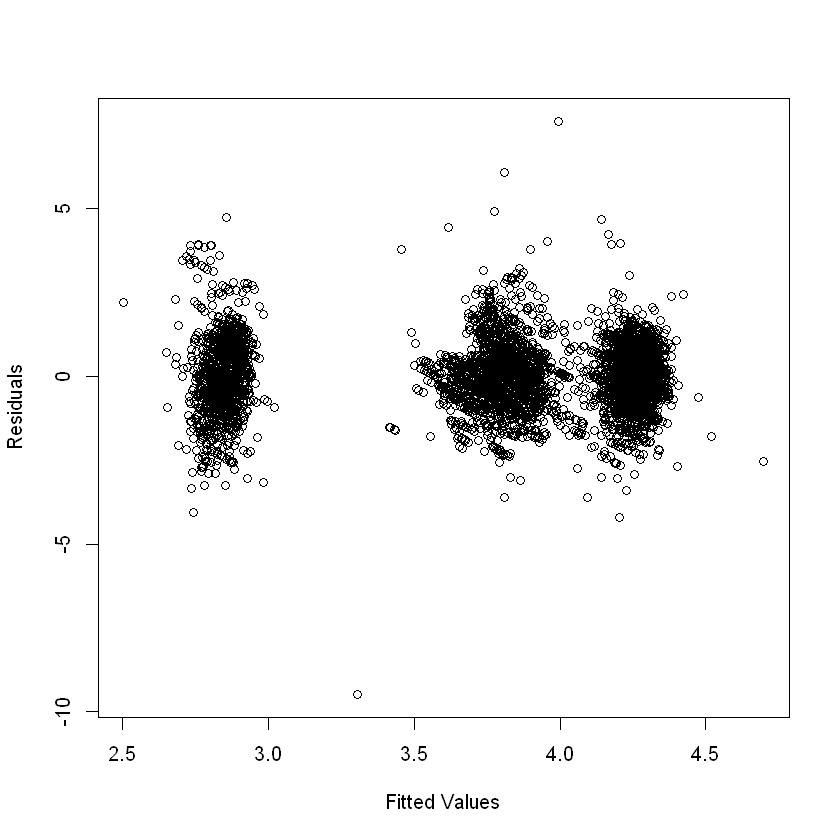

In [49]:
# examining the three clusters in the data
plot(full.fitted, full.resid, xlab="Fitted Values", ylab="Residuals")

In the code below, we assign colors to the different states found in our data
and plot the results which clearly shows that our data is clustered by state.

In [50]:
# create a data frame of the fitted and residual values
residual_df = data.frame
residual_df = cbind(full.fitted, 
                    full.resid,
                    dataAdult.red$State)
residual_df = data.frame(residual_df)

# set the column names
colnames(residual_df) = c('fitted',
                          'residual',
                          'state')

# assign colors based on the state
residual_df = residual_df %>% 
  mutate(color = case_when(residual_df$state == 'LA' ~ 'orange',
                           residual_df$state == 'AR' ~ 'blueviolet',
                           residual_df$state == 'AL' ~ 'green',
                           residual_df$state == 'NC' ~ 'cyan',
                           TRUE ~ "ERROR"))

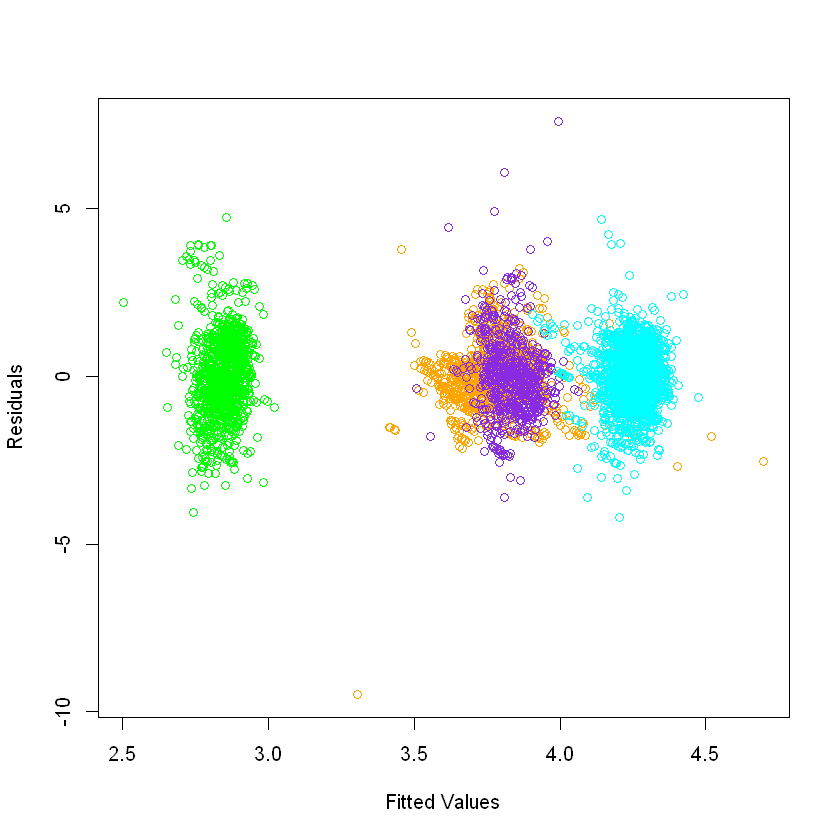

In [51]:
# plot the same graph with colors added
plot(residual_df$fitted,
     residual_df$residual,
     col = residual_df$color,
     ylab = 'Residuals',
     xlab = 'Fitted Values')

Below, we implement group lasso regression with groupings based on state.

In [52]:
# create dataframe including the outcome
group_df_1 = dataAdult[,-c(1,3,4,5)]
group_df_1$EDCost.pmpm = dataAdult$EDCost/dataAdult$PMPM

# assign grouping numbers based on state
group_df_1 = group_df_1 %>% 
  mutate(State_s = case_when(group_df_1$State == 'LA' ~ 1,
                           group_df_1$State == 'AR' ~ 2,
                           group_df_1$State == 'AL' ~ 3,
                           group_df_1$State == 'NC' ~ 4,
                           TRUE ~ 5))

group_df_1 = group_df_1 %>% 
  mutate(Urbanicity_grp = case_when(group_df_1$Urbanicity == 'Urban' ~ 1,
                             group_df_1$Urbanicity == 'Suburban' ~ 2,
                             group_df_1$Urbanicity == 'Rural' ~ 3,
                             TRUE ~ 4))

#Group index for x variables
group_DA = c(1,2,3,3,3,4,4,4,5,5,5,5,6,7,8,9,10,11,12,13,14,15)


In [53]:
colnames(group_df_1)

[1] "State"            "HO"               "PO"               "WhitePop"        
 [5] "BlackPop"         "OtherPop"         "HealthyPop"       "ChronicPop"      
 [9] "ComplexPop"       "Unemployment"     "Income"           "Poverty"         
[13] "Education"        "Urbanicity"       "Accessibility"    "Availability"    
[17] "RankingsPCP"      "RankingsFood"     "RankingsHousing"  "RankingsExercise"
[21] "RankingsSocial"   "ProvDensity"      "EDCost.pmpm"      "State_s"         
[25] "Urbanicity_grp"

In [54]:
length(colnames(group_df_1))

[1] 25

The above chunk of code defines the group index for predicting variables. Before that, we assign grouping numbers based on state and urbanicity.

In [55]:
set.seed(100)
# vector of outcome values
Y = as.vector(log(group_df_1$EDCost.pmpm))

# matrix of predictor values removing categorical variables and the outcome column
X = as.matrix(group_df_1[,-c(1,14,23)])

# set the test data to be 20% of the overall data
test_size = 0.2

# create the train and test indices
group_train_ind = createDataPartition(Y, p = 1 - test_size, list = FALSE)

# Split the data into train and test sets
group_train_data = X[group_train_ind, ]
group_test_data = X[-group_train_ind, ]

# Split the response variable accordingly
group_train_response = Y[group_train_ind]
group_test_response = Y[-group_train_ind]

# perform group lasso regression using the state groupings
model_group_11 = glmnet(X, Y, alpha = 1, group = group_DA, nlambda=100)

# Calculate the optimal lambda using cross-validation
group_lasso.cv <- cv.grpreg(X, Y, group = group_DA, family = "poisson", nfolds = 10)
opt_lambda <- group_lasso.cv$lambda.min

In [56]:
# Perform group lasso using grpreg
group_lasso = grpreg(X, Y, group = group_DA, penalty = "grLasso", 
                     family = "poisson", nlambda = 100)

# group_lasso_coefficients <- coef(group_lasso)
# group_lasso_coefficients

In [57]:
round(select(group_lasso)$beta,4)

(Intercept)               HO               PO         WhitePop 
   -8.839380e+07     3.142600e+00     4.762000e-01     1.959081e+05 
        BlackPop         OtherPop       HealthyPop       ChronicPop 
    1.959081e+05     1.959081e+05     6.880299e+05     6.880300e+05 
      ComplexPop     Unemployment           Income          Poverty 
    6.880300e+05     0.000000e+00     0.000000e+00     0.000000e+00 
       Education    Accessibility     Availability      RankingsPCP 
    0.000000e+00     0.000000e+00     0.000000e+00     0.000000e+00 
    RankingsFood  RankingsHousing RankingsExercise   RankingsSocial 
    0.000000e+00     0.000000e+00     1.500000e-03    -2.200000e-03 
     ProvDensity          State_s   Urbanicity_grp 
    0.000000e+00     0.000000e+00     0.000000e+00

We’re implementing Group LASSO with the group previously defined. Then we apply the cv.grpreg() in order to identify the optimal lambda using 10-fold cross validation and fit the Group LASSO using the grpreg() command. The estimated coefficients are shown above. Coefficients equal to zero indicating that this variable is not selected such as RankingsSocial.

In [58]:
# perform k-fold cross validation to find the optimal lambda value
set.seed(100)

# perform group lasso regression using the state groupings
model_group_11 = glmnet(X, Y, alpha = 1, group = group_DA, nlambda=100)

model_group_11_fit = cv.glmnet(X, Y, alpha = 1, lambda=NULL, grouped = TRUE, nfolds=10)

# find the optimal lambda value
optml_lambda = model_group_11_fit$lambda.min

# view the coefficients of the model at the optimal lambda
coef(model_group_11,optml_lambda)

23 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)       3.651369e+00
HO                1.884278e+01
PO                2.077976e+00
WhitePop         -4.354805e-03
BlackPop          .           
OtherPop          6.556571e-03
HealthyPop       -2.659867e-02
ChronicPop        .           
ComplexPop        2.804813e-03
Unemployment      .           
Income            2.753702e-07
Poverty          -2.681596e-03
Education        -1.614158e-03
Accessibility    -4.511172e-03
Availability      6.924052e-02
RankingsPCP      -1.695255e-04
RankingsFood      2.047757e-02
RankingsHousing   .           
RankingsExercise  7.112714e-03
RankingsSocial   -1.359402e-02
ProvDensity       9.333652e-02
State_s          -1.343332e-02
Urbanicity_grp   -2.327813e-02

Here, we use glmnet to perform Group LASSO and corresponding coefficient estimates are shown above.

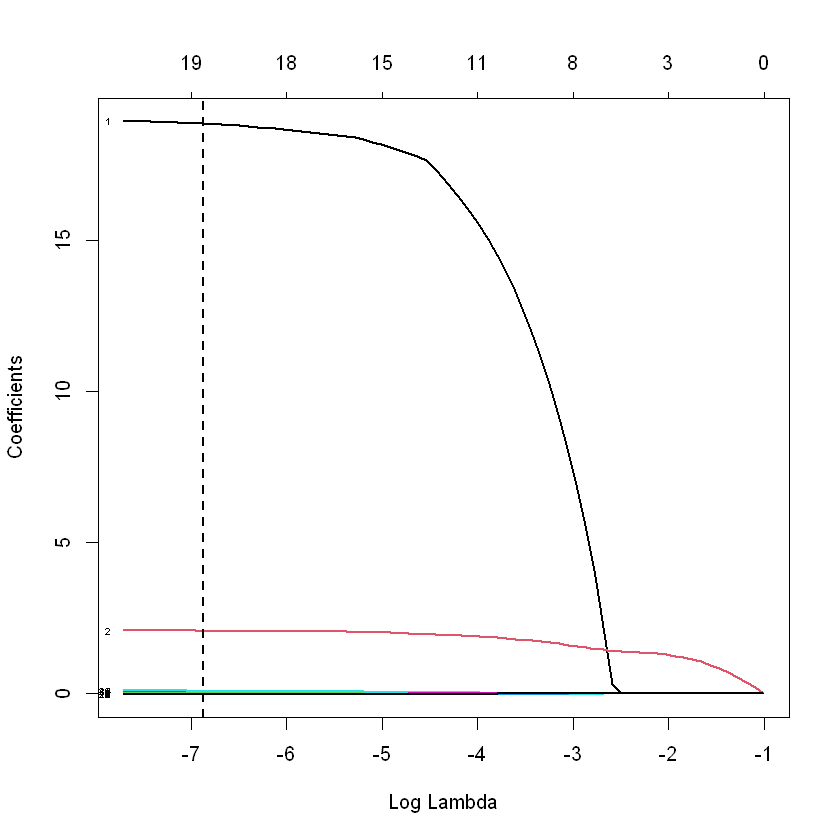

In [59]:
# plot the coefficient paths
plot(model_group_11, xvar='lambda', label=TRUE, lwd=2) 
abline(v=log(optml_lambda), col='black', lty=2, lwd=2)

In [60]:
# Perform group lasso regression on the training data
model_group_2 = glmnet(x = group_train_data, y = group_train_response, alpha = 1, 
                       group = group_DA, lambda = opt_lambda)

We perform Group LASSO regression on the training data to fit the model, which is then used for testing on the test dataset.

In [61]:
# Make predictions on the group lasso model
group.pred = predict(model_group_2, newx = group_test_data, type = "response")

# compare predicted values to true values
group_compare = data.frame(group_test_response, group.pred)
group_compare$diff = group_compare$group_test_response - group_compare$s0
colnames(group_compare) = c('Actual', 'Predicted', 'Difference')

In [62]:
# calculate MAE of group lasso model
group_mae = mean(abs(group_compare$Actual - group_compare$Predicted))

In [63]:
# calculate RMSE of group lasso model
group_rmse = sqrt(mean((group_compare$Actual - group_compare$Predicted)^2))

In [64]:
# calculate R2 of the group lasso model
group_ss_residual = sum((group_compare$Actual - group_compare$Predicted)^2)
group_ss_total = sum((group_compare$Actual - mean(group_compare$Actual))^2)
group_r_squared = 1 - (group_ss_residual / group_ss_total)

In [65]:
# calculate adjusted R2 of the group lasso model
adjusted_r_squared = 1 - ((1 - group_r_squared) * (nrow(group_compare) - 1)) / (nrow(group_compare) - ncol(group_test_data) - 1)

In [66]:
# make a dataframe of the different measures
group_performance = data.frame(MAE = group_mae,
                               RMSE =group_rmse,
                               R2 = group_r_squared,
                               Adj_R2 = adjusted_r_squared)
round(group_performance,4)


MAE,RMSE,R2,Adj_R2
<dbl>,<dbl>,<dbl>,<dbl>
0.2882,0.372,0.6002,0.5912


The above codes are calculating MAE, RMSE, R^2 and Adj_R^2. According to R^2, the Group LASSO model explains ~60% of the variance in the test data. MAE and RMSE are relatively low, suggesting good predictive performance. Meanwhile, the small difference between R^2 and Adj_R^2 indicates that most of the predictors contribute useful information.